EDA --> [Link](https://www.kaggle.com/code/ustcer1984/steel-plate-eda-s4e3)  
RF/XGB/LGBM & model explaination --> [Link](https://www.kaggle.com/code/ustcer1984/steel-plate-rf-xgb-lgbm-model-explaination-s4e3)

### Objective

- Compare original data vs. train data
- Study how to use original data to improve score

In [1]:
# setup environment
input_path = './data/'
output_path = './output03/'

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # show all columns

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() # I like seaborn default theme

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn.inspection import permutation_importance
import shap

import pickle

import warnings
warnings.filterwarnings('ignore') # suppress warning msg

In [2]:
# load raw data
df_train_raw = pd.read_csv(input_path + 'train.csv') # train dataset
df_test_raw = pd.read_csv(input_path + 'test.csv') # test dataset
df_origin_raw = pd.read_csv(input_path + 'Steel Plates Faults.csv') # original dataset

predict_features = df_train_raw.columns.to_list()[-7:]

# X transformer function
def X_transformer(X_raw):
    X = X_raw.copy()
    X['X_Center'] = (X['X_Maximum'] + X['X_Minimum'])/2
    X['X_Range'] = X['X_Maximum'] - X['X_Minimum']
    X['Y_Center'] = (X['Y_Maximum'] + X['Y_Minimum'])/2
    X['Y_Range'] = X['Y_Maximum'] - X['Y_Minimum']
    X['Aspect_Ratio'] = X['Y_Perimeter'] / X['X_Perimeter']
    X['Mean_Luminosity'] = X['Sum_of_Luminosity'] / X['Pixels_Areas']
    X['Delta_Luminosity'] = X['Maximum_of_Luminosity'] - X['Minimum_of_Luminosity']
    X['Log_Pixel_Resolution'] = ((10**X['LogOfAreas']) / X['Pixels_Areas']).apply(np.log10)
    if 'id' in X.columns:
        X.drop(columns=['id'], inplace=True)
    return X

df_origin = X_transformer(df_origin_raw)
df_train = X_transformer(df_train_raw)
df_test = X_transformer(df_test_raw)

### Original *vs.* Train datasets

According to competition info, the train and test datasets were generated from a deep learning model trained on the [Steel Plates Faults](https://archive.ics.uci.edu/dataset/198/steel+plates+faults) dataset from UCI. It worths to study how we can use the original dataset to improve competiton score.

Simple comparison between the original and train datasets shows:  
- **Noise** is intentionally **added** into the train datasets.
- Some data contain **extreme noise** which effectively make them **outliers**.

Below are some examples.

In [3]:
print('Is the defect label unique for each sample?\n')
print('Original dataset:')
print(df_origin[predict_features].sum(axis=1).value_counts())
print('\nTrain dataset:')
print(df_train[predict_features].sum(axis=1).value_counts())

Is the defect label unique for each sample?

Original dataset:
1    1941
Name: count, dtype: int64

Train dataset:
1    18380
0      818
2       21
Name: count, dtype: int64


- Orignal dataset all show unique defect label.
- Train dataset has zero and dual labelled data.

In [4]:
print('Is type of steel unique?\n')
print('Original dataset:')
print(df_origin[['TypeOfSteel_A300', 'TypeOfSteel_A400']].sum(axis=1).value_counts())
print('\nTrain dataset:')
print(df_train[['TypeOfSteel_A300', 'TypeOfSteel_A400']].sum(axis=1).value_counts())

Is type of steel unique?

Original dataset:
1    1941
Name: count, dtype: int64

Train dataset:
1    19198
0       20
2        1
Name: count, dtype: int64


- Orignal dataset all show unique `TypeOfSteel` label.
- Train dataset has zero and dual labelled data.

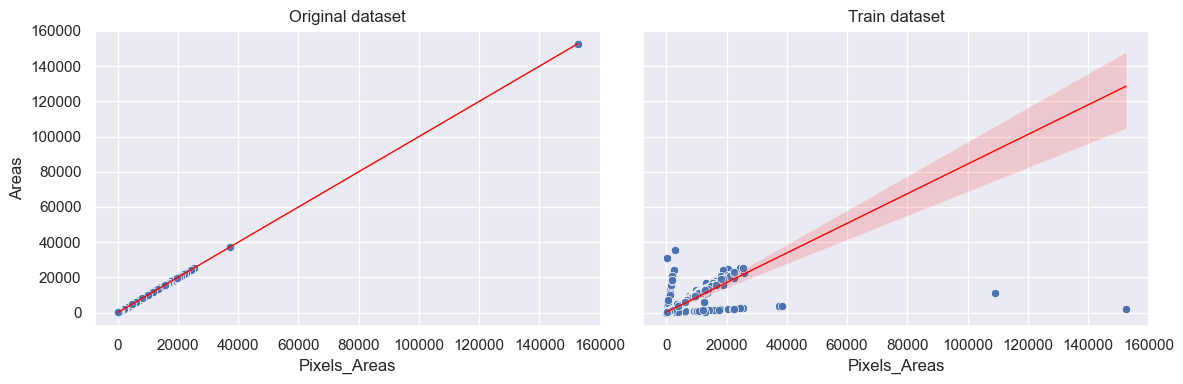

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
sns.scatterplot(x=df_origin['Pixels_Areas'], y=10**df_origin['LogOfAreas'], ax=axs[0])
sns.regplot(x=df_origin['Pixels_Areas'], y=10**df_origin['LogOfAreas'], ax=axs[0], 
            scatter_kws={'s':0}, color='red', line_kws={'linewidth':1})
axs[0].set_title('Original dataset')
axs[0].set_ylabel('Areas')
sns.scatterplot(x=df_train['Pixels_Areas'], y=10**df_train['LogOfAreas'], ax=axs[1])
sns.regplot(x=df_train['Pixels_Areas'], y=10**df_train['LogOfAreas'], ax=axs[1], 
            scatter_kws={'s':0}, color='red', line_kws={'linewidth':1})
axs[1].set_title('Train dataset')
axs[1].set_ylabel('Areas')
fig.tight_layout()
fig.show()

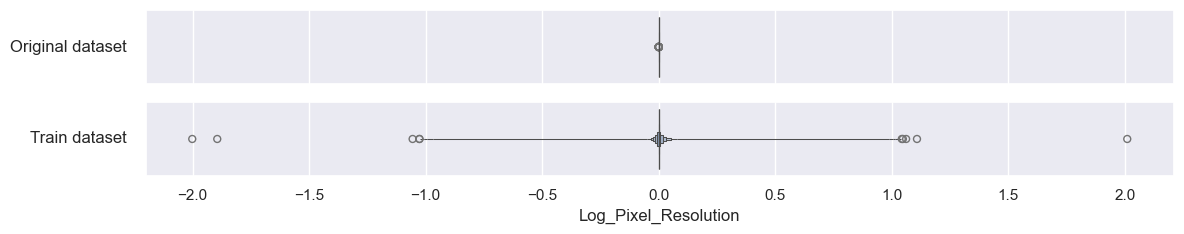

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(12, 2.5), sharex=True)
sns.boxenplot(x=df_origin['Log_Pixel_Resolution'], ax=axs[0])
axs[0].set_ylabel('Original dataset', rotation=0, ha='right', va='center')
sns.boxenplot(x=df_train['Log_Pixel_Resolution'], ax=axs[1])
axs[1].set_ylabel('Train dataset', rotation=0, ha='right', va='center')
fig.tight_layout()
fig.show()

- Original dataset `LogOfAreas` is simply calculated from `Pixels_Areas`.
- Train dataset added many extreme noise cases.
    - My previous [EDA](https://www.kaggle.com/code/ustcer1984/steel-plate-eda-s4e3) suggested machine **resolution** setting issue, but now I understand it is **purely noise issue**!

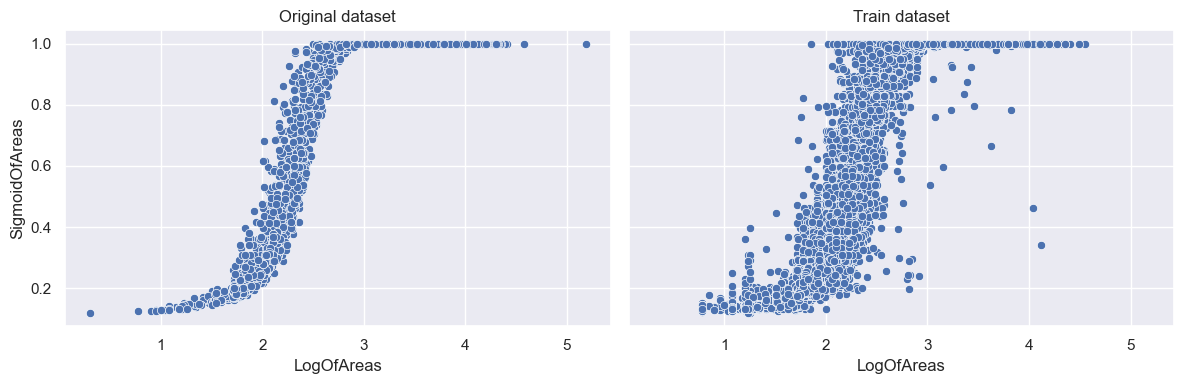

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
sns.scatterplot(x=df_origin['LogOfAreas'], y=df_origin['SigmoidOfAreas'], ax=axs[0])
axs[0].set_title('Original dataset')
sns.scatterplot(x=df_train['LogOfAreas'], y=df_train['SigmoidOfAreas'], ax=axs[1])
axs[1].set_title('Train dataset')
fig.tight_layout()
fig.show()

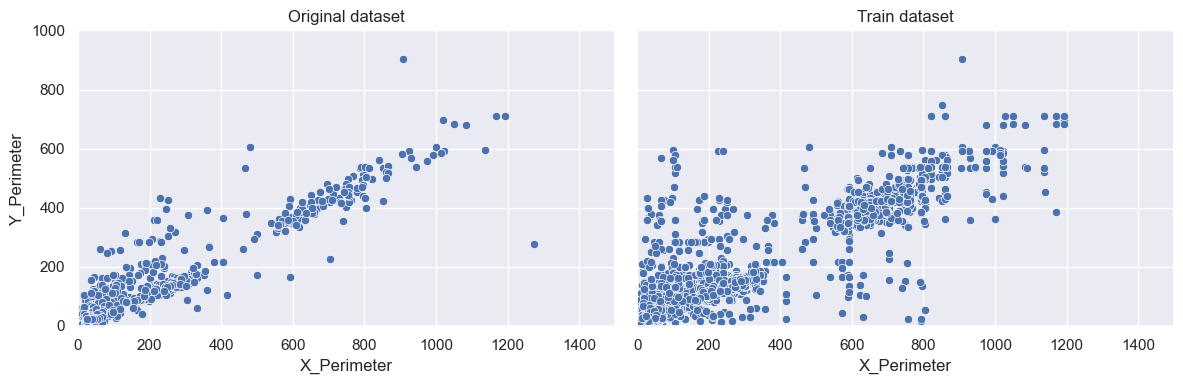

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
sns.scatterplot(x=df_origin['X_Perimeter'], y=df_origin['Y_Perimeter'], ax=axs[0])
axs[0].set_title('Original dataset')
sns.scatterplot(x=df_train['X_Perimeter'], y=df_train['Y_Perimeter'], ax=axs[1])
axs[1].set_title('Train dataset')
plt.xlim(0, 1500)
plt.ylim(0, 1000)
fig.tight_layout()
fig.show()

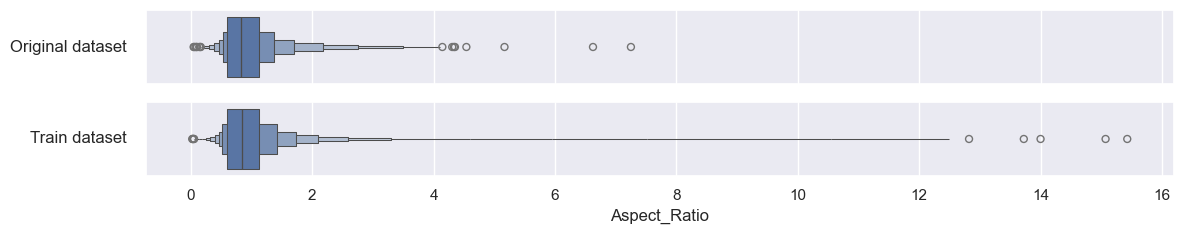

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(12, 2.5), sharex=True)
sns.boxenplot(x=df_origin['Aspect_Ratio'], ax=axs[0])
axs[0].set_ylabel('Original dataset', rotation=0, ha='right', va='center')
sns.boxenplot(x=df_train['Aspect_Ratio'], ax=axs[1])
axs[1].set_ylabel('Train dataset', rotation=0, ha='right', va='center')
fig.tight_layout()
fig.show()

As much as possible we want to remove the data with outlier from the train dataset, since we don't want our model to learn noise feature.

<br>

**Ideas to trim outliers from train dataset**  
1. For categorical feature, trim all data with categories not exsiting in original dataset.
    - e.g. zero and dual defect labelling
2. For numerical features, based on each defect type, trim all data outside the range of original dataset.

In [10]:
df_train_trim = df_train.copy()
df_train_trim['trim'] = [False] * df_train_trim.shape[0] # label row trim decision

# trim categorical features
## trim non unique defect type
df_train_trim['trim'] = df_train_trim['trim'] | \
                        (df_train_trim[predict_features].sum(axis=1) != 1)
## trim non unique TypeOfSteel
df_train_trim['trim'] = df_train_trim['trim'] | \
                        (df_train_trim[['TypeOfSteel_A300', 'TypeOfSteel_A400']].sum(axis=1) != 1)
## Outside_Global_Index
df_train_trim['trim'] = df_train_trim['trim'] | \
                        (df_train_trim['Outside_Global_Index'].isin(df_origin['Outside_Global_Index'])==False)

# special treatment on Log_Pixel_Resolution
df_train_trim['trim'] = df_train_trim['trim'] | \
                        df_train_trim['Log_Pixel_Resolution'].gt(0.2) | \
                        df_train_trim['Log_Pixel_Resolution'].lt(-0.2)

num_features = set(df_train.columns) - set(predict_features) - \
               set(['Log_Pixel_Resolution', 'TypeOfSteel_A300', 
                    'TypeOfSteel_A400', 'Outside_Global_Index'])

def iqr_range(s, coef=1.5):
    """Find boundary for outlier detection.
    Return: low_boundary, high_boundary
    Inpur: s [pd.Series]
    """
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    return q1 - coef*iqr, q3 + coef*iqr

# trim num_features based on range
for feature in num_features:
    for defect in predict_features:
        # f_min, f_max = iqr_range(df_origin[df_origin[defect]==1][feature], 12)
        f_min = df_origin[df_origin[defect]==1][feature].min()
        f_max = df_origin[df_origin[defect]==1][feature].max()
        trim = (
            (df_train_trim[defect]==1) &
            (df_train_trim[feature].lt(f_min) | df_train_trim[feature].gt(f_max))
        )
        # print(feature + ': ' + str(trim.sum()))
        df_train_trim['trim'] = df_train_trim['trim'] | trim

Train dataset trim ratio = 25.3%

Is the defect label unique for each sample?

Original dataset:
1    1941
Name: count, dtype: int64

Train_trim dataset:
1    14361
Name: count, dtype: int64


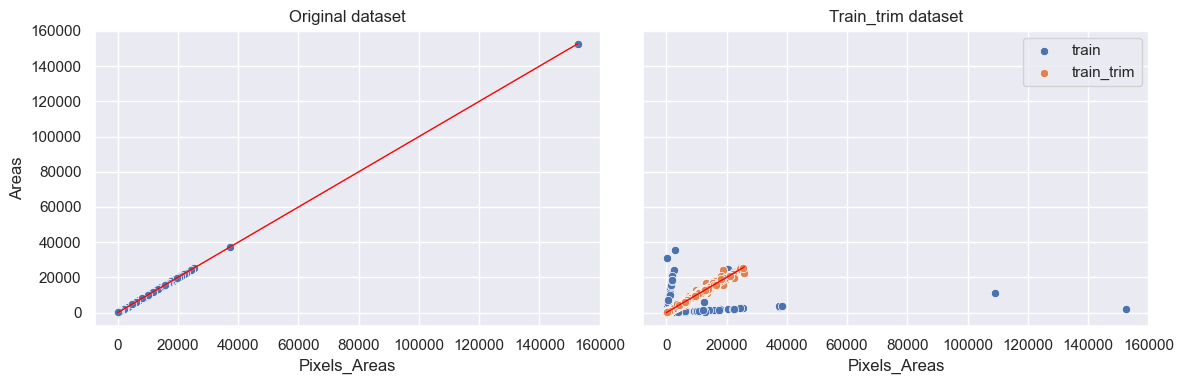

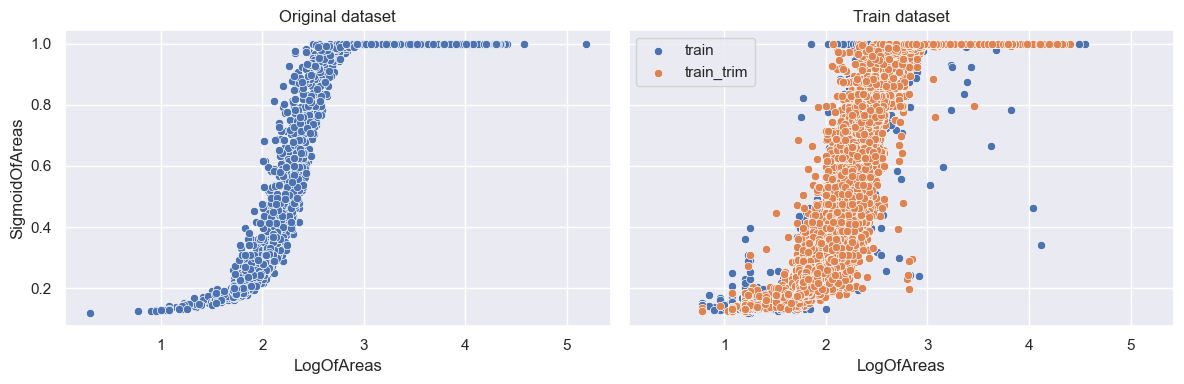

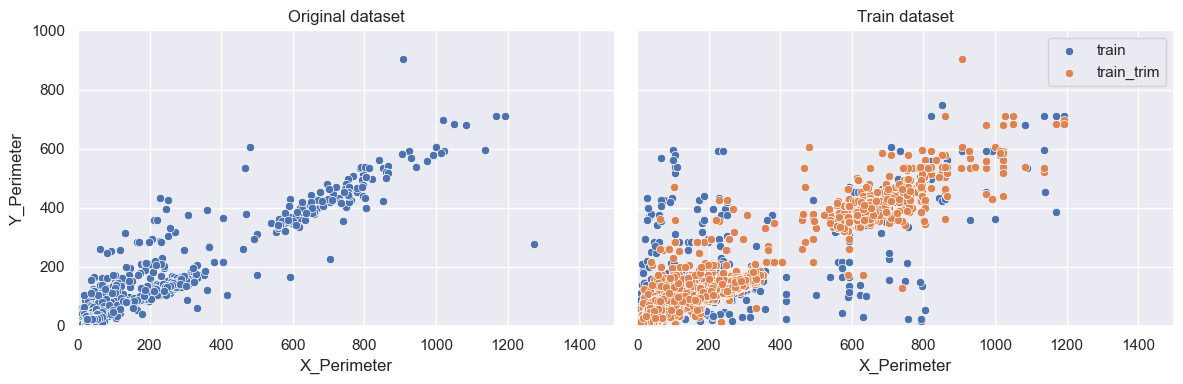

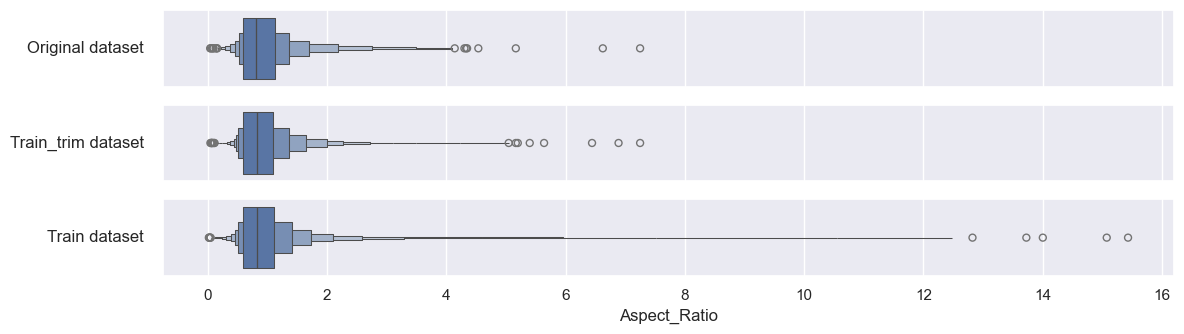

In [11]:
df_temp = df_train[df_train_trim['trim']==False]
print(f"Train dataset trim ratio = {df_train_trim['trim'].mean():.1%}\n")

print('Is the defect label unique for each sample?\n')
print('Original dataset:')
print(df_origin[predict_features].sum(axis=1).value_counts())
print('\nTrain_trim dataset:')
print(df_temp[predict_features].sum(axis=1).value_counts())

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
sns.scatterplot(x=df_origin['Pixels_Areas'], y=10**df_origin['LogOfAreas'], ax=axs[0])
sns.regplot(x=df_origin['Pixels_Areas'], y=10**df_origin['LogOfAreas'], ax=axs[0], 
            scatter_kws={'s':0}, color='red', line_kws={'linewidth':1})
axs[0].set_title('Original dataset')
axs[0].set_ylabel('Areas')
sns.scatterplot(x=df_train['Pixels_Areas'], y=10**df_train['LogOfAreas'], ax=axs[1], label='train')
sns.scatterplot(x=df_temp['Pixels_Areas'], y=10**df_temp['LogOfAreas'], ax=axs[1], label='train_trim')
sns.regplot(x=df_temp['Pixels_Areas'], y=10**df_temp['LogOfAreas'], ax=axs[1], 
            scatter_kws={'s':0}, color='red', line_kws={'linewidth':1})
axs[1].set_title('Train_trim dataset')
axs[1].set_ylabel('Areas')
fig.tight_layout()
fig.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
sns.scatterplot(x=df_origin['LogOfAreas'], y=df_origin['SigmoidOfAreas'], ax=axs[0])
axs[0].set_title('Original dataset')
sns.scatterplot(x=df_train['LogOfAreas'], y=df_train['SigmoidOfAreas'], ax=axs[1], label='train')
sns.scatterplot(x=df_temp['LogOfAreas'], y=df_temp['SigmoidOfAreas'], ax=axs[1], label='train_trim')
axs[1].set_title('Train dataset')
fig.tight_layout()
fig.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
sns.scatterplot(x=df_origin['X_Perimeter'], y=df_origin['Y_Perimeter'], ax=axs[0])
axs[0].set_title('Original dataset')
sns.scatterplot(x=df_train['X_Perimeter'], y=df_train['Y_Perimeter'], ax=axs[1], label='train')
sns.scatterplot(x=df_temp['X_Perimeter'], y=df_temp['Y_Perimeter'], ax=axs[1], label='train_trim')
axs[1].set_title('Train dataset')
plt.xlim(0, 1500)
plt.ylim(0, 1000)
fig.tight_layout()
fig.show()

fig, axs = plt.subplots(3, 1, figsize=(12, 3.5), sharex=True)
sns.boxenplot(x=df_origin['Aspect_Ratio'], ax=axs[0])
axs[0].set_ylabel('Original dataset', rotation=0, ha='right', va='center')
sns.boxenplot(x=df_temp['Aspect_Ratio'], ax=axs[1])
axs[1].set_ylabel('Train_trim dataset', rotation=0, ha='right', va='center')
sns.boxenplot(x=df_train['Aspect_Ratio'], ax=axs[2])
axs[2].set_ylabel('Train dataset', rotation=0, ha='right', va='center')
fig.tight_layout()
fig.show()

Looks effective!

<br>

### Effect on score

Now we are ready to explore the effect on final score.

**Experiment Setup**  
- Model: `LGBMClassifier` with default parameter
- Experiments:
    1. `train` dataset (control group: including outliers)
    2. `train_trim` dataset
    3. `origin` dataset
    4. `origin` + `train_trim` dataset
    5. `origin` + `train` dataset
- Compare all experiment model scores against same `val` dataset
    - `val` dataset is splitted from train data and including outliers

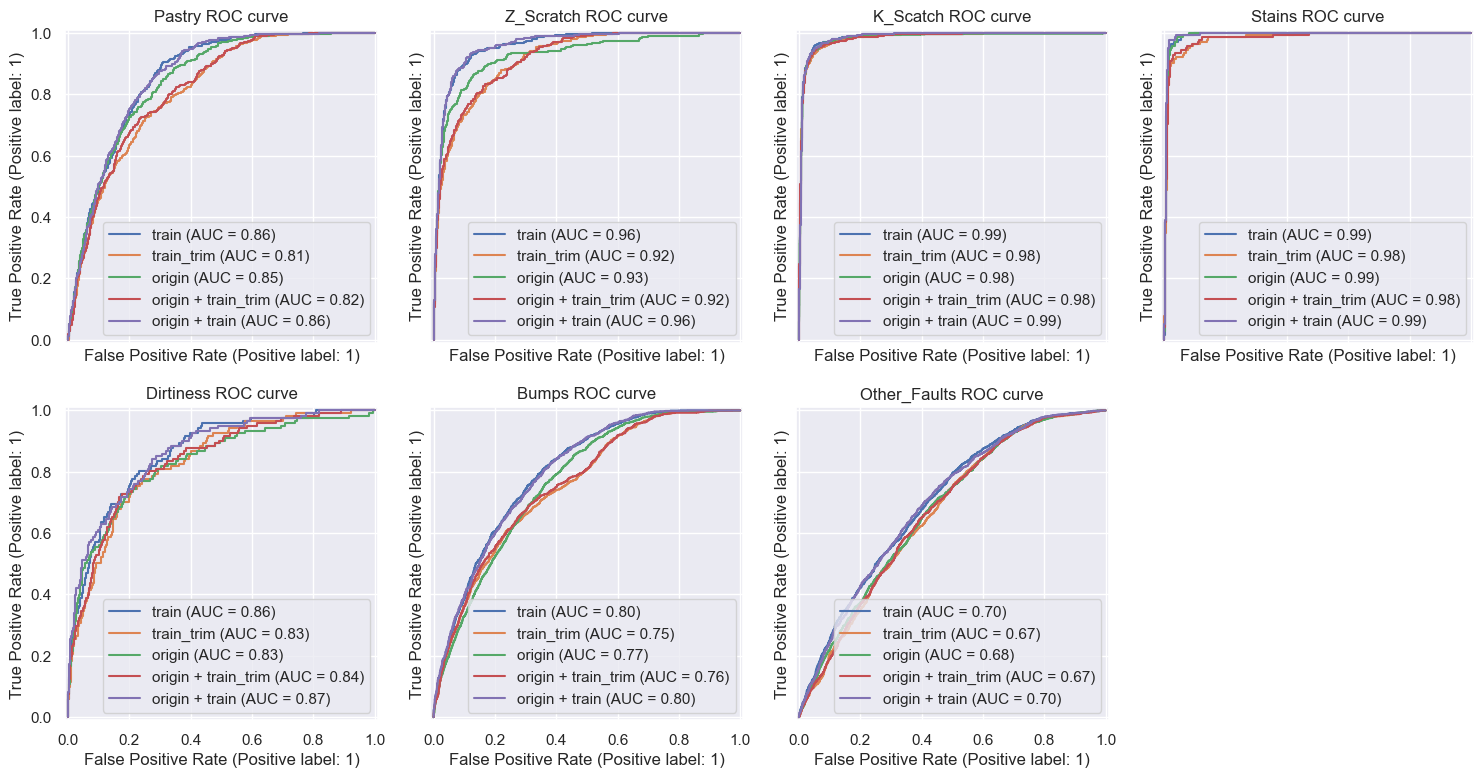

In [12]:
# stratify on defect type and outlier
stratify = np.zeros(df_train_trim.shape[0])
for defect in predict_features:
    stratify = 10*stratify + df_train_trim[defect]
stratify = stratify.apply(lambda x: 10001 if x in [10010, 1010000] else x)
stratify = 10*stratify + df_train_trim['trim']

df_train_1, df_val = train_test_split(df_train_trim, test_size=.25, 
                                      stratify=stratify, random_state=42)
df_train_1.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

df_train_2 = df_train_1[df_train_1['trim']==False].reset_index(drop=True)

df_val.drop(columns=['trim'], inplace=True)
df_train_1.drop(columns=['trim'], inplace=True)
df_train_2.drop(columns=['trim'], inplace=True)

df_train_3 = df_origin.copy()
df_train_4 = pd.concat([df_train_3, df_train_2], axis=0).reset_index(drop=True)
df_train_5 = pd.concat([df_train_3, df_train_1], axis=0).reset_index(drop=True)

Xs_train = [df_train_1.drop(columns=predict_features),
            df_train_2.drop(columns=predict_features),
            df_train_3.drop(columns=predict_features),
            df_train_4.drop(columns=predict_features),
            df_train_5.drop(columns=predict_features)]
Ys_train = [df_train_1[predict_features],
            df_train_2[predict_features],
            df_train_3[predict_features],
            df_train_4[predict_features],
            df_train_5[predict_features]]
X_val = df_val.drop(columns=predict_features)
Y_val = df_val[predict_features]

summary = {'Dataset': ['train', 'train_trim', 'origin', 'origin + train_trim', 'origin + train']}
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, 
                        figsize=(15, 8))
for defect in predict_features:
    summary[defect] = []
    for i in range(len(summary['Dataset'])):
        X_train = Xs_train[i]
        y_train = Ys_train[i][defect]
        y_val = Y_val[defect]
        # fit model
        model = LGBMClassifier(n_jobs=-1, random_state=314, verbose=-1)
        model.fit(X_train, y_train)
        y_score = model.predict_proba(X_val)[:, 1]
        auc_score = metrics.roc_auc_score(y_val, y_score)
        summary[defect].append(auc_score)
        # plot
        ax = axs[predict_features.index(defect)//4][predict_features.index(defect)%4]
        ax.set_title(defect + ' ROC curve')
        metrics.RocCurveDisplay.from_estimator(model, X_val, y_val,
                                               name=summary['Dataset'][i], ax=ax)
fig.delaxes(axs[1][3])
fig.tight_layout()
fig.show()

In [13]:
df_summary = pd.DataFrame(summary)
df_summary.set_index('Dataset', inplace=True)
df_summary['Average_AUC'] = df_summary.mean(axis=1)
df_summary

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,Average_AUC
Dataset,,,,,,,,
train,0.859189,0.958324,0.986428,0.992804,0.863342,0.799310,0.699725,0.879874
train_trim,0.813473,0.916986,0.982720,0.982318,0.833564,0.754910,0.667746,0.850245
origin,0.847498,0.927005,0.982978,0.992298,0.833336,0.766244,0.675474,0.860691
origin + train_trim,0.819614,0.919263,0.983054,0.982747,0.838344,0.758725,0.670980,0.853247
origin + train,0.859686,0.959552,0.985736,0.993536,0.866415,0.798550,0.698052,0.880218


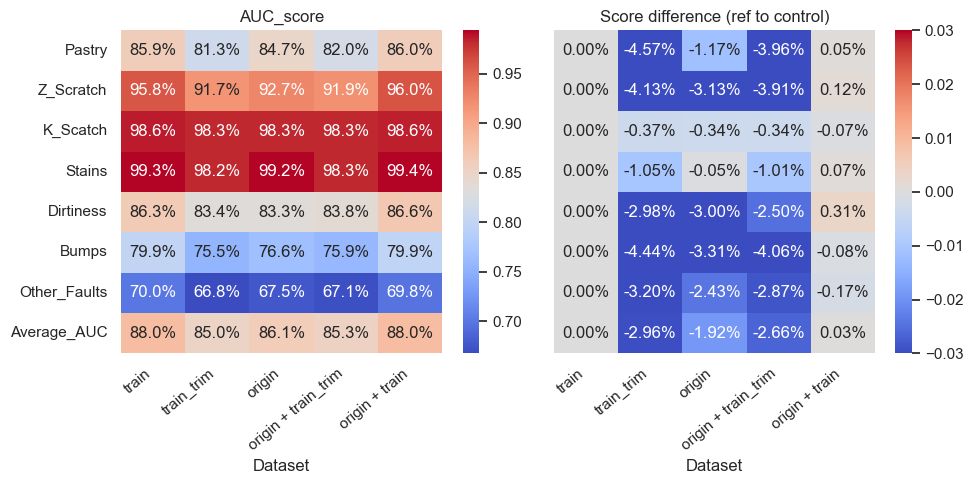

In [14]:
df_summary_t = df_summary.transpose()
df_summary_d = df_summary_t.copy()
for col in df_summary_t.columns:
    df_summary_d[col] = df_summary_d[col] - df_summary_t['train']
# plot heatmap
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.heatmap(df_summary_t, annot=True, fmt='.1%', ax=axs[0], cmap='coolwarm')
axs[0].set_title("AUC_score")
sns.heatmap(df_summary_d, annot=True, fmt='.2%', ax=axs[1], cmap='coolwarm', vmax=0.03, vmin=-0.03)
axs[1].set_title('Score difference (ref to control)')
axs[0].set_xticklabels(df_summary_t.columns, rotation=40, ha='right')
axs[1].set_xticklabels(df_summary_t.columns, rotation=40, ha='right')
fig.tight_layout()

- Only `origin + train` shows slight improvement.
- Removing outliers from `train` significantly worsen the model performance.
    - It seems the deep learning model is **NOT** simply adding random noise. There is pattern / structure inside.

In [15]:
# prepare submit files
df_train_1 = df_train_trim.copy()
df_train_2 = df_train_1[df_train_1['trim']==False].reset_index(drop=True)

df_train_1.drop(columns=['trim'], inplace=True)
df_train_2.drop(columns=['trim'], inplace=True)

df_train_3 = df_origin.copy()
df_train_4 = pd.concat([df_train_3, df_train_2], axis=0).reset_index(drop=True)
df_train_5 = pd.concat([df_train_3, df_train_1], axis=0).reset_index(drop=True)

Xs_train = [df_train_1.drop(columns=predict_features),
            df_train_2.drop(columns=predict_features),
            df_train_3.drop(columns=predict_features),
            df_train_4.drop(columns=predict_features),
            df_train_5.drop(columns=predict_features)]

Ys_train = [df_train_1[predict_features],
            df_train_2[predict_features],
            df_train_3[predict_features],
            df_train_4[predict_features],
            df_train_5[predict_features]]

datasets = ['train', 'trim', 'origin', 'origin_trim', 'origin_train']
for i in range(len(datasets)):
    dataset = datasets[i]
    df_submit = df_test_raw[['id']]
    for defect in predict_features:
        X_train = Xs_train[i]
        y_train = Ys_train[i][defect]
        # fit model
        model = LGBMClassifier(n_jobs=-1, random_state=314, verbose=-1)
        model.fit(X_train, y_train)
        df_submit[defect] = model.predict_proba(df_test)[:, 1]
    df_submit.to_csv(output_path+dataset+' submit.csv', index=False)